In [89]:
import math
import os
import random

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructField, StructType

import settings as settings
from logic.hasher import Hasher
from logic.loader import LoaderStrategy
from logic.utils import timeit
from logic.vectorizator import Vectorizator

# Если hadoop_home уже настроен это трока не нужна
os.environ['HADOOP_HOME'] = r"D:\Programms\Spark\spark-2.4.4-bin-hadoop2.7"


def distance(one, other) -> float:
    """
    Get euclidian distance between to vectors
    :param one: First vector
    :param other: Second vector
    :return: euclidian distance between to vectors
    """
    summa = 0.0
    for d in range(len(one)):
        delta = one[d] - other[d]
        summa += delta * delta
    return math.sqrt(summa)


def load_hasher_vectorizer(loader, spark) -> (Hasher, Vectorizator):
    """
    Load hasher and vectorizer
    :param loader: Loader?
    :param spark: Spark session?
    :return: loaded hasher and vectorizer
    """
    spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 100 * 1024 * 1024)

    tech_path = settings.TECH_PATH
    filepath = loader.join(tech_path, 'hash')

    hasher = Hasher(spark, loader, filepath, bucket_length=0.0001,
                    num_hash_tables=1)
    hasher.load()
    vectorizator = Vectorizator(spark, loader, tech_path, sparse=False)
    vectorizator.load()
    return hasher, vectorizator


def vectors_generating(loader) -> (List, List):
    """
    Generate two different vectors without nulls from availiable values
    :param loader: Loader?
    :return: two vectors
    """
    input_path = settings.INPUT_DATA_PATH
    filename = loader.get_path(input_path, "availiableValues.txt")

    fr = open(filename, "r")

    vals = fr.read().splitlines()
    vec1 = ["1", "3359", "-12862"]
    vec2 = ["1", "3359", "-12862"]

    for v in vals:
        t = v.split('|')
        firstVal = t[random.randint(0, len(t) - 1)]
        while firstVal is None or firstVal == "":
            firstVal = t[random.randint(0, len(t) - 1)]

        secondVal = t[random.randint(0, len(t) - 1)]
        while secondVal is None or secondVal == "" or secondVal == firstVal:
            secondVal = t[random.randint(0, len(t) - 1)]
        vec1.append(firstVal)
        vec2.append(secondVal)

    return vec1, vec2


def save_vectors(vec1: List, vec2: List) -> (str, str):
    """
    Save two vectors
    :param vec1: first vector to save
    :param vec2: second vector to save
    :return: filename of where vectors were saved
    """
    fn1 = "rand_vector1.txt"
    fn2 = "rand_vector2.txt"

    fw1 = open(fn1, "w")
    fw2 = open(fn2, "w")

    v1 = '|'.join(map(str, vec1))
    v2 = '|'.join(map(str, vec2))
    fw1.write(v1)
    fw2.write(v2)
    return fn1, fn2


def nullcheck(spark, vectorizator: Vectorizator,h, fn1: str, fn2: str, schema: StructType) -> List:
    """
    Vectorize segment, find distance. Load from file
    :param spark: Spark session?
    :param vectorizator: Vectorizator
    :param fn1: filename of first df
    :param fn2: filename of second df
    :param schema: Column names for dfs
    :return: list of distances between dfs
    """
    # segment preparation
    with timeit('Read segment from file: {time:.2f} s.'):
        df = spark.read.csv(fn1, header='false', schema=schema, sep="|")

    print('Loaded vectorization model')
    selected_columns = ['PERSON_ID', 'FEATURES']
    df = vectorizator.transform(df, selected_columns, '2_df_vectorized_not_sparse.parquet')

    with timeit('Read segment from file: {time:.2f} s.'):
        df_seg = spark.read.csv(fn2, header='false', schema=schema, sep="|")

    n_segment = df_seg.count()
    print(f'n segment: {n_segment}.')

    df_seg = vectorizator.transform(df_seg, selected_columns, '2_segment_vectorized_not_sparse.parquet')

    nz_pairs_distance = df.crossJoin(df_seg).withColumn("ABS_DISTANCE", squared_udf(df.FEATURES, df_seg.FEATURES))

    nz_pairs_distance.show(20)

    avail = nz_pairs_distance.take(nz_pairs_distance.count())
    res = avail[0].asDict()["ABS_DISTANCE"]
    return res


def nullmaking_list(loader, spark, vectorizator: Vectorizator, h, vec1: List, vec2: List) -> str:
    """
    Get distance for each null colums
    :param loader: Loader?
    :param spark: Spark session?
    :param vectorizator: Vectorizator
    :param vec1: vector to create first df
    :param vec2: vector to create second df
    :return: string with distances between dfs with null in each column
    """
    input_path = settings.INPUT_DATA_PATH
    filename = loader.get_path(input_path, "seg_col_names.txt")
    columns_seg = open(filename).read().splitlines()
    columns = [StructField(column, StringType(), True) for column in columns_seg]
    schema = StructType(columns)

    res = ""
    h1 = ""
    h2 = ""
    v1 = vec1.copy()
    v2 = vec2.copy()
    inf = nullcheck_list(spark, vectorizator, h, v1, v2, schema)
    res += str(inf[0]) + '\n'
    h1 += str(inf[1]) + '\n'
    h2 += str(inf[2]) + '\n'
    for i in range(3, len(vec1)):
        v1 = vec1.copy()
        v2 = vec2.copy()
        v1[i] = None
        v2[i] = None
        print(v1)
        inf = nullcheck_list(spark, vectorizator, h, v1, v2, schema)
        res += str(inf[0]) + '\n'
        h1 += str(inf[1]) + '\n'
        h2 += str(inf[2]) + '\n'

    return res[:-1], h1[:-1], h2[:-1]


def nullcheck_list(spark, vectorizator: Vectorizator,h, vec1: List, vec2: List, schema: StructType) -> List:
    """
    Vectorize segment, find distance. Load from list
    :param spark: Spark session?
    :param vectorizator: Vectorizator
    :param vec1: vector to create first df
    :param vec2: vector to create second df
    :param schema: Column names for dfs
    :return: list of distances between dfs
    """
    spark.udf.register("dist", distance)
    squared_udf = udf(distance)

    with timeit('Read segment from file: {time:.2f} s.'):
        df = spark.createDataFrame(
            [
                vec1,
            ],
            schema=schema
        )

    selected_columns = ['PERSON_ID', 'FEATURES']
    df = vectorizator.transform(df, selected_columns, '2_df_vectorized_not_sparse.parquet')
    
    df_t1 = h.transform(df)
    df_t1.show()
    hash1 = df_t1.take(df_t1.count())
    h1 = hash1[0].asDict()["HASHES"][0][0]
    with timeit('Read segment from file: {time:.2f} s.'):
        df_seg = spark.createDataFrame(
            [
                vec2,
            ],
            schema=schema
        )

    n_segment = df_seg.count()
    print(f'n segment: {n_segment}.')

    df_seg = vectorizator.transform(df_seg, selected_columns, '2_segment_vectorized_not_sparse.parquet')

    df_t2 = h.transform(df_seg)
    df_t2.show()
    hash2 = df_t2.take(df_t2.count())
    h2 = hash2[0].asDict()["HASHES"][0][0]
    
    nz_pairs_distance = df.crossJoin(df_seg).withColumn("ABS_DISTANCE", squared_udf(df.FEATURES, df_seg.FEATURES))

    nz_pairs_distance.show(20)

    avail = nz_pairs_distance.take(nz_pairs_distance.count())
    res = avail[0].asDict()["ABS_DISTANCE"]
    

    return res, h1, h2

def Nmaxelements(list1: List, n: int) -> List:
    """
    Get indexes of n max elements in a list
    :param list1: list of elements
    :param n: amount of max elements to get
    :return: list of indexes of max elements in a list
    """
    list1 = list(map(float, list1))
    final_list = np.array(list1).argsort()[-n:]
    return final_list


def Nminelements(list1: List, n: int) -> List: 
    """
    Get indexes of n min elements in a list
    :param list1: list of elements
    :param n: amount of min elements to get
    :return: list of indexes of min elements in a list
    """
    list1 = list(map(float, list1))
    final_list = np.array(list1).argsort()[:n]
    return final_list


def min_max_nullmaking_list(loader, spark, vectorizator: Vectorizator,h, vec1: List,vec2: List, list_to_null: List) -> str:
    """
    Get distance for n null colums in df
    :param loader: Loader?
    :param spark: Spark session?
    :param vectorizator: Vectorizator
    :param vec1: vector to create first df
    :param vec2: vector to create second df
    :param list_to_null: list of column indexes to nullify
    :return: string with distances between dfs with n null in a row
    """
    vec1 = vec1.copy()
    vec2 = vec2.copy()
    filename = loader.get_path(input_path, "seg_col_names.txt")
    columns_seg = open(filename).read().splitlines()
    columns = [StructField(column, StringType(), True) for column in columns_seg]
    schema = StructType(columns)
    
    res = ""
    h1 = ""
    h2 = ""
    for i in list_to_null:
        vec1[i+3] = None
        vec2[i+3] = None
    print(vec1)
    inf = nullcheck_list(spark, vectorizator, h, vec1, vec2, schema)
    res += str(inf[0]) + '\n'
    h1 += str(inf[1])
    h2 += str(inf[2])

    return res, h1, h2

In [95]:
def get_spark_memory(cpus: int):
    mapping = {
        4: 11,
        16: 56,
        64: 244
    }
    return f'{mapping.get(cpus, 3)}g'


def get_spark_session(loader_type: str, cpus: int) -> SparkSession:
    """Create SparkSession with different config for different parameters."""
    spark = SparkSession.builder.master(f"local[{cpus}]")
    if loader_type == 's3':
        spark = spark.config('spark.jars.packages',
                             'org.apache.hadoop:hadoop-aws:2.7.6')
    spark = spark \
        .config('spark.driver.memory', get_spark_memory(cpus))
    return spark.getOrCreate()


if __name__ == '__main__':
    with timeit('Total time for `main.py`: {time:.2f} s.'):
        # initialize Spark
        spark = get_spark_session(settings.LOADER, settings.CPU_COUNT)
        sc: SparkContext = spark.sparkContext
        print(f'spark.driver.memory: {sc.getConf().get("spark.driver.memory")}')
        print(f'spark.master: {sc.getConf().get("spark.master")}')

        # initialize loader
        root_path = settings.ROOT_PATH
        loader = LoaderStrategy.get_loader(settings.LOADER)(
            sc=sc, root_path=root_path)
        print(f'Root path in loader: {loader.root_path}')

        # select action
        action = settings.ALGORITHM_ID
        print(f'Action: {action}')
#         h, v = load_hasher_vectorizer(loader, spark)
#         vec1, vec2 = vectors_generating(loader)
#         fn1, fn2 = save_vectors(vec1, vec2)
        input_path = settings.INPUT_DATA_PATH
#         res = ""
#         if action == 1:
#             res = nullmaking_list(loader, spark, v,h, vec1, vec2)
#         else:
#             raise ValueError(f'Action {action} is not recognized.')
#         fwh1 = open("vec1Hashes.txt", "w")
#         fwh1.write(res[1])
#         fwh2 = open("vec2Hashes.txt", "w")
#         fwh2.write(res[2])
#         fwh1.close()
#         fwh2.close()

#         fw = open("nulls_stats.txt", "w")
#         fw.write(res[0])
#         fw.close()
        fr = open("nulls_stats.txt", "r")
        res_dist = fr.read()   
        res_list = res_dist.splitlines()[1:]
        
        vec1 = open("rand_vector1.txt", "r").read().split('|')
        vec2 = open("rand_vector2.txt", "r").read().split('|')

#         fw1 = open("maxes.txt", "w")
#         fw2 = open("mins.txt", "w")

        fwmaxh = open("maxesHash.txt", "w")
        fwminh = open("minsHash.txt", "w")

        for i in range(2, len(res_list)+1):
            max_list = Nmaxelements(res_list, i)
            min_list = Nminelements(res_list, i)
            max_res = min_max_nullmaking_list(loader, spark, v,h, vec1,vec2, max_list)
            min_res = min_max_nullmaking_list(loader, spark, v,h, vec1,vec2, min_list) 

#             fw1.write(max_res[0])
#             fw2.write(min_res[0])
            fwmaxh.write(max_res[1]+'|'+max_res[2]+'\n')
            fwminh.write(min_res[1]+'|'+min_res[2]+'\n')

#         fw2.close()
#         fw1.close()
        fwmaxh.close()
        fwminh.close()

------------------------------ 
Current Time:  18:32:22
spark.driver.memory: 3g
spark.master: local[6]
Root path in loader: 
Action: 1
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', None, 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', None]
------------------------------ 
Current Time:  18:32:22
Read segment from file: 0.06 s.
------------------------------ 
Current Time:  18:32:24
Write transformed df to file: 4.52 s.
------------------------------ 


In [131]:
import os
from functools import reduce
from typing import List
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pyspark.sql.functions as f
from matplotlib.axes import Axes
from pyspark.sql import DataFrame
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql.types import *
import re
def autolabel(ax: Axes, rects, is_float: bool=True):
        """
        Attach a text label above each bar in *rects*, displaying its height.
        :param ax: Axes to draw info on
        :param rects: bars of plot to draw labels on
        :param is_float: if values on plot are float values(for normalized values for example)
        :return:
        """
        alls = []
        for rect in rects:
            height = rect.get_height()
            pattern = '{0:.2f}' if is_float else '{}'
            ax.annotate(pattern.format(height if is_float else int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

            
def show_plot_for_distance_in_each_null_column(ax: Axes, values: List, xlbl, ylbl, is_float):
    """
    function to represent distance changes from different null column in a row
    :param ax: Axes to draw info on
    :param values: values to represent
    :return: None
    """
    bar_width = 1
    rec = []
    delta = 1
    v = [i for i in range(len(values))]
    values = [float(i) for i in values]
    rec.append(ax.bar(np.array(v)+bar_width-delta, np.array(values),  width=bar_width, edgecolor='white'))    
    ax.grid()
    
    for r in rec:
        autolabel(ax, r, is_float)
    ax.set_xticks(np.arange(len(values)))
    ax.set_xticklabels(range(0, len(values)))
    ax.set_xlabel("index of null column(index 0 for no null at all)")
    ax.set_ylabel("Distance between vectors")
    
def show_plot_for_distance_in_several_null_column(ax: Axes, values: List, xlbl, ylbl, is_float):
    """
    function to represent distance changes from different null amount in a row
    :param ax: Axes to draw info on
    :param values: values to represent
    :return: None
    """
    bar_width = 1
    rec = []
    delta = 1
    v = [i for i in range(len(values))]
    values = [float(i) for i in values]
    rec.append(ax.bar(np.array(v)+bar_width-delta, np.array(values),  width=bar_width, edgecolor='white'))    
    ax.grid()
    
    for r in rec:
        autolabel(ax, r, is_float)
    ax.set_xticks(np.arange(len(values)+1))
    ax.set_xticklabels(range(2, len(values) + 2))
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)

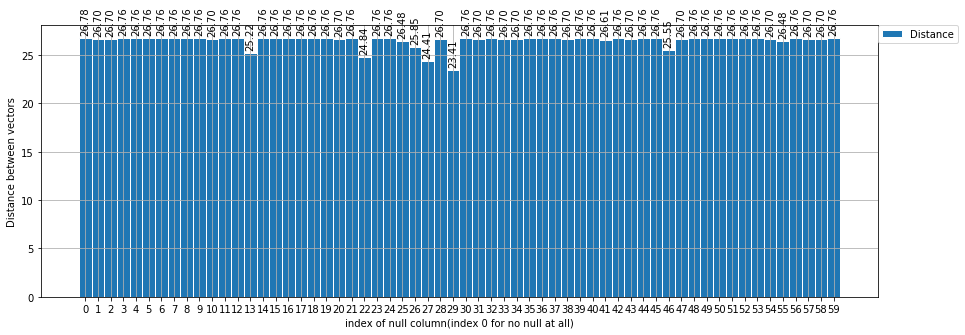

In [136]:
fig, ax = plt.subplots(figsize=(15,5))
res_list = open("nulls_stats.txt","r").read().splitlines()
xlbl = "Amount of null columns in a row"
ylbl = "Distance between vectors"
show_plot_for_distance_in_each_null_column(ax, res_list,xlbl,ylbl, True)
ax.legend(["Distance"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

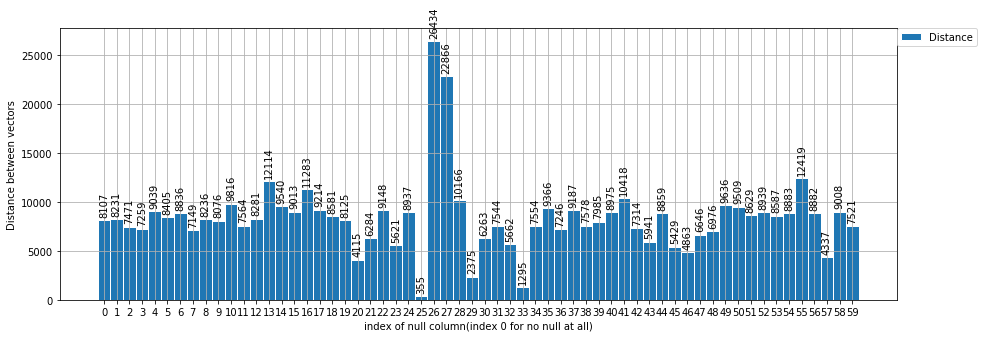

In [142]:
fig, ax = plt.subplots(figsize=(15,5))
h1_list = open("vec1Hashes.txt","r").read().splitlines()
h2_list = open("vec2Hashes.txt","r").read().splitlines()

diff_list = []
for i in range(len(h1_list)):
    hash1 = int(float(h1_list[i]))
    hash2 = int(float(h2_list[i]))
    diff_list.append(abs(hash1-hash2))
xlbl = "Amount of null columns in a row"
ylbl = "Distance between hashes"
show_plot_for_distance_in_each_null_column(ax, diff_list,xlbl, ylbl, False)
ax.legend(["Distance"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

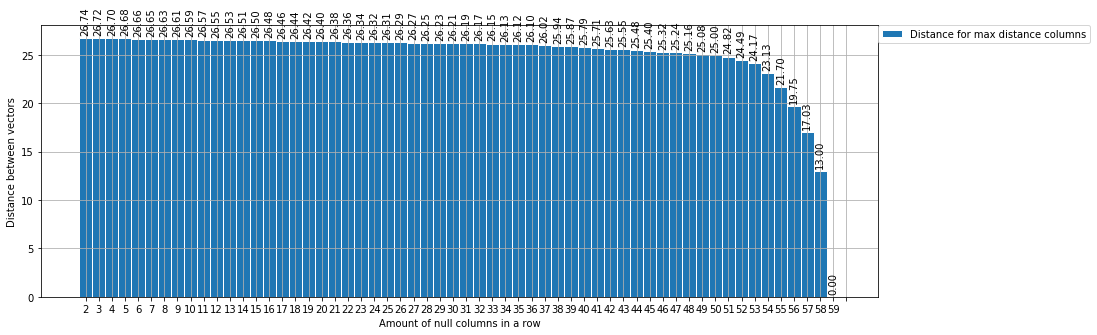

In [138]:
fig, ax = plt.subplots(figsize=(15,5))
max_list = open("maxes.txt","r").read().splitlines()
xlbl = "Amount of null columns in a row"
ylbl = "Distance between vectors"
show_plot_for_distance_in_several_null_column(ax, max_list, xlbl, ylbl, True)
ax.legend(["Distance for max distance columns"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

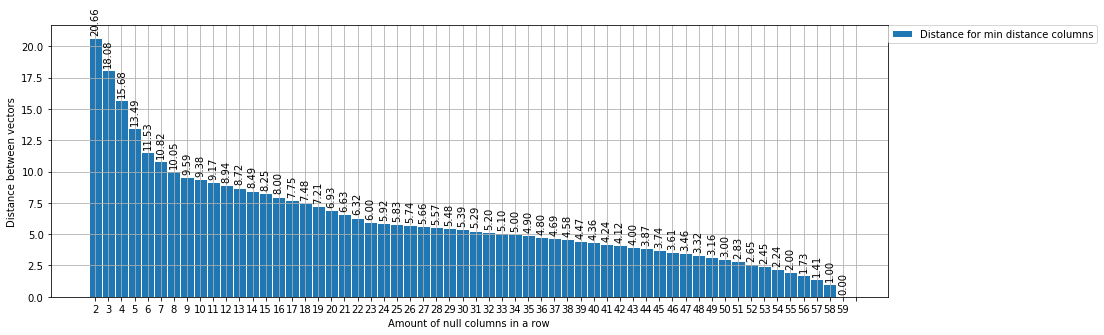

In [139]:
fig, ax = plt.subplots(figsize=(15,5))
min_list = open("mins.txt", "r").read().splitlines()
xlbl = "Amount of null columns in a row"
ylbl = "Distance between vectors"
show_plot_for_distance_in_several_null_column(ax, min_list, xlbl, ylbl, True)
ax.legend(["Distance for min distance columns"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

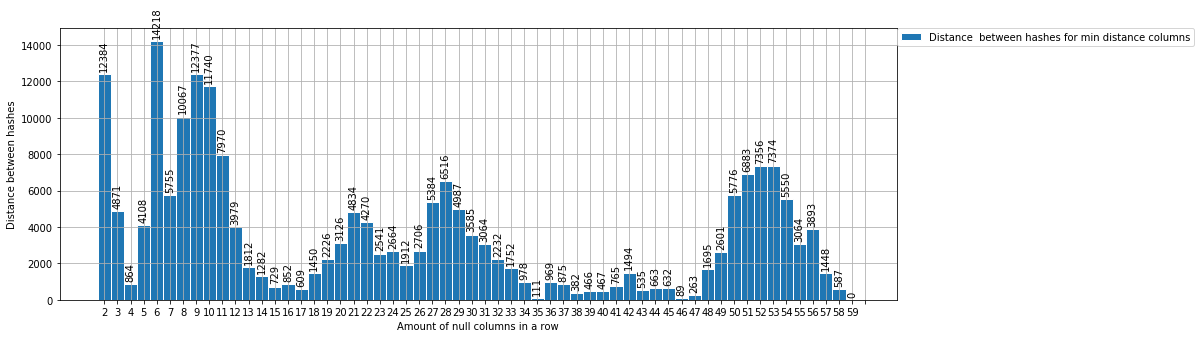

In [140]:
fig, ax = plt.subplots(figsize=(15,5))
min_list_hash = open("minsHash.txt", "r").read().splitlines()
diff_list = []
for v in min_list_hash:
    hashes = v.split('|')
    hash1 = int(float(hashes[0]))
    hash2 = int(float(hashes[1]))
    diff_list.append(abs(hash1-hash2))
xlbl = "Amount of null columns in a row"
ylbl = "Distance between hashes"
show_plot_for_distance_in_several_null_column(ax, diff_list, xlbl, ylbl, False)
ax.legend(["Distance  between hashes for min distance columns"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

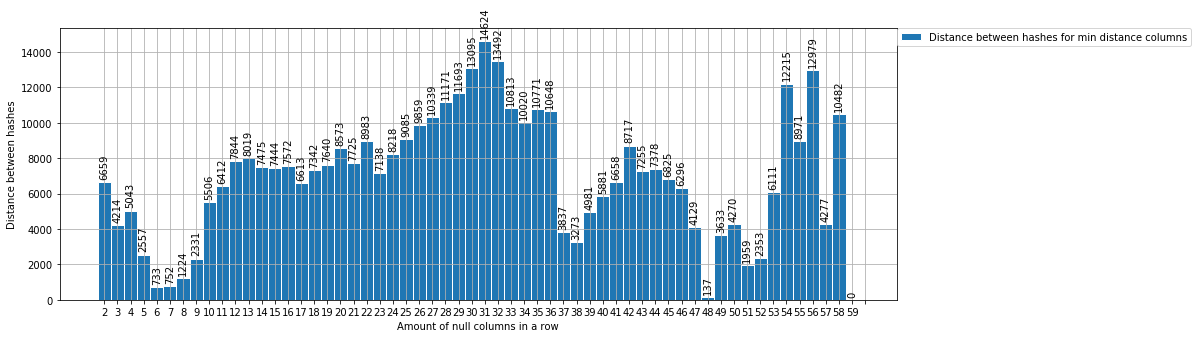

In [141]:
fig, ax = plt.subplots(figsize=(15,5))
max_list_hash = open("maxesHash.txt", "r").read().splitlines()
diff_list = []
for v in max_list_hash:
    hashes = v.split('|')
    hash1 = int(float(hashes[0]))
    hash2 = int(float(hashes[1]))
    diff_list.append(abs(hash1-hash2))
xlbl = "Amount of null columns in a row"
ylbl = "Distance between hashes"
show_plot_for_distance_in_several_null_column(ax, diff_list, xlbl, ylbl, False)
ax.legend(["Distance between hashes for min distance columns"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()